Integration of patient data
------------------------------

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]=  str(0)

Imports
-----------

In [2]:
import configs, functions_v2, dataset_classes_v1, mymodels

import pandas as pd
import numpy as np
import copy


import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score


Setting the parameter of the experiment
-----------------

In [3]:
# to do: hier alle Möglichkeiten (base, appraoch 1,2,3) eintragen
class Hparams(): 
    def __init__(self): 
        self.gpu = str(0)
        self.experiment_id= 'cfgs6'
        dataset = [['lab2'],['lab2', 'lab1']]
        setting = ['K', 'K+F']
        self.dataset = dataset[1]
        self.mode = 'base'
        self.encoding_scheme = 'unscaled'
        self.setting = setting[1]
        self.splits =  13
        self.batch_size = 128
        self.metadata_list =  ['age', 'gender', 'location']
        self.test_flag =  False
        self.num_epochs = 30 
        self.epoch_fine_tuning = 10
        self.runs =  5
        self.hidden1 = 2048 #2048, 512
        self.meta_out = 512 # 512, 256
        self.combined_metadata = []
        self.samples_list = []
        self.labels_matrix = []
        self.rs = 1 
        self.num_workers = 5
        self.dropout = 0.3
        self.nr_tiles = 0 
        self.overview_results = []

Load the trained models
---------------------

In [4]:
hparams = Hparams()
path = configs.get_path_to_trained_model("base")
model_paths = path +  '0'# todo: pseudo

In [5]:
rp = configs.get_result_path()
result_path =  rp + hparams.experiment_id + '/'
if not os.path.exists(result_path):
    os.makedirs(result_path)
print('-'*30)
print('General settings')
print('-'*30)

print('Starting experiment ', hparams.experiment_id)
device = torch.device('cuda:'+hparams.gpu if torch.cuda.is_available() else 'cpu')
print('Using device ', device)
print('Dataset: ', hparams.dataset)
print('Mode: ', hparams.mode)
print('Encoding: ', hparams.encoding_scheme)
    
# --------------------------
# Load the data of the two cohorts 
# --------------------------
file_path_lab2, csv_path_lab2, result_path_lab2 = configs.get_paths('lab2', hparams.experiment_id)
file_path_lab1, csv_path_lab1, result_path_lab1 = configs.get_paths('lab1', hparams.experiment_id)
metadata_lab2 = pd.read_csv(csv_path_lab2)
metadata_lab2['lab'] = np.array([0]*len(metadata_lab2['slide_name']))
metadata_lab1 = pd.read_csv(csv_path_lab1)
metadata_lab1['lab'] = np.array([1]*len(metadata_lab1['slide_name']))
    
metadata = pd.DataFrame(
{ 'slide_name': metadata_lab2.slide_name.tolist() + metadata_lab1.slide_name.tolist(), 
 'label': metadata_lab2.label.tolist() + metadata_lab1.label.tolist(), 
 'age': metadata_lab2.age.tolist() + metadata_lab1.age.tolist(), 
 'gender': metadata_lab2.gender.tolist() + metadata_lab1.gender.tolist(), 
 'location': metadata_lab2.location.tolist() + metadata_lab1.location.tolist(), 
 'UV': metadata_lab2.UV.tolist() + metadata_lab1.UV.tolist(), 
 'lab': metadata_lab2.lab.tolist() + metadata_lab1.lab.tolist()   
})

# --------------------------
# Handling Missing data 
# --------------------------
print('-'*30)
print('Handling Missing data')
print('-'*30)
list_of_keys = ['age', 'gender', 'location', 'UV', 'label', 'lab']
hparams.combined_metadata, hparams.labels_matrix = functions_v2.handling_missing_data(metadata, list_of_keys)
print('-'*30)
print('Take a look at the data:')
print('-'*30)
print(hparams.combined_metadata.head())

# --------------------------
# Get the sample list (paths to all slides in one list)
# --------------------------
samples_list = []
for sn in metadata_lab2.slide_name: 
    samples_list.append(file_path_lab2 + '/' + str(sn))
for sn in metadata_lab1.slide_name: 
    samples_list.append(file_path_lab1 + '/' + str(sn))
print('Dataset includes {} slides'.format(len(samples_list)))
hparams.samples_list = np.asarray(samples_list)
   
# --------------------------
# Stratified data split (training, validation, test set creation)
# --------------------------
print('-'*30)
print('Data splitting (stratificated)')
print('-'*30)
print('13 Folds are created among which the metadata is equally distributed. 2 folds are used for the validation, 4 for the test and the remaining for the training set ')
path_set_folds, path_set_folds_indices = functions_v2.split_samples_with_sk_multilearn_v1(hparams.splits, hparams.rs, hparams.samples_list, hparams.labels_matrix, hparams.combined_metadata,
                                                                                          result_path= result_path)
# --------------------------
# Encoding of the patient data  
# --------------------------
print('-'*30)
print('Encoding')
print('-'*30)
hparams.combined_metadata = functions_v2.encodings_v1(hparams.combined_metadata, hparams.encoding_scheme)
print(hparams.combined_metadata.head())

# --------------------------
# Transformations  
# --------------------------
data_transforms = {
'train': transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale = (0.7,1.0)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.0), shear=None),
    transforms.ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=0.01),
    transforms.RandomHorizontalFlip(), # Vertical Flip? 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]), 
'test': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# --------------------------
# Create datasets
# --------------------------
print('-'*30)
print('Creation of datasets: Sizes (#tiles)')
print('-'*30)
image_datasets = {}
path_set = path_set_folds

image_datasets['train'] = dataset_classes_v1.CustomizedDataset_Fusion(path_set = path_set['train'], metadata=hparams.combined_metadata, rs_tiles = hparams.rs, nr_tiles = 0,
                                                                  transform=data_transforms['train'], non_image = hparams.metadata_list,  encoding_scheme = hparams.encoding_scheme)
image_datasets['val'] = dataset_classes_v1.CustomizedDataset_Fusion(path_set = path_set['val'], metadata=hparams.combined_metadata, rs_tiles = hparams.rs, nr_tiles = 0,
                                                                transform=data_transforms['val'], non_image = hparams.metadata_list,  encoding_scheme = hparams.encoding_scheme)
image_datasets['test'] = dataset_classes_v1.CustomizedDataset_Fusion(path_set = path_set['test'], metadata=hparams.combined_metadata, rs_tiles = hparams.rs, nr_tiles = 0,
                                                                 transform=data_transforms['test'],non_image = hparams.metadata_list,  encoding_scheme = hparams.encoding_scheme)
print('Size Trainset:', len(image_datasets['train']))
print('Size Validationset:', len(image_datasets['val']))
print('Size Testset:', len(image_datasets['test']))

# --------------------------
# Create dataloaders
# --------------------------
dataloaders = {
        'train': torch.utils.data.DataLoader(image_datasets['train'],batch_size=hparams.batch_size, shuffle=True, num_workers=hparams.num_workers, drop_last = True),
        'val' : torch.utils.data.DataLoader(image_datasets['val'],batch_size=hparams.batch_size, shuffle= True, num_workers=hparams.num_workers, drop_last = True), 
        'test' : torch.utils.data.DataLoader(image_datasets['test'],batch_size=hparams.batch_size, shuffle= False, num_workers=hparams.num_workers,  drop_last = False)}

# --------------------------
# Model architecture
# --------------------------
print('-'*30)
print('Model Baseline/Image feature extractor of fusion approaches')
print('-'*30)
model = torchvision.models.resnext50_32x4d(pretrained=True)

# baseline and feature extractor for fusion approaches 
if hparams.mode == 'base': 
    print('Mode ', hparams.mode)
    for param in model.parameters():
        param.requires_grad = False
    criterion = nn.CrossEntropyLoss()

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

if hparams.encoding_scheme == 'onehot': 
    meta_in = 0 
    if 'age' in hparams.metadata_list: 
        meta_in += 2
    if 'location' in hparams.metadata_list: 
        meta_in +=3
    if 'gender' in hparams.metadata_list: 
        meta_in += 2
    print('Encoding via onehot: meta_in parameter: ', meta_in)
else: 
    meta_in = len(hparams.metadata_list)
print('meta_in parameter (not relevant if mode is "base"): ', meta_in)

model.to(device)
print('load model .. ')
model.load_state_dict(torch.load(model_paths,  map_location='cuda:0'))
model.to(device)

------------------------------
General settings
------------------------------
Starting experiment  cfgs6
Using device  cuda:0
Dataset:  ['lab2', 'lab1']
Mode:  base
Encoding:  unscaled
------------------------------
Handling Missing data
------------------------------
age
number of missing data:  15
For age, replace by the mean age:  52.25721153846154
gender
number of missing data:  15
For gender, replace by the most common gender:  0
location
number of missing data:  24
For location, replace by the most common location:  0
UV
number of missing data:  29
For location, replace by the most common location:  0
label
number of missing data:  0
lab
number of missing data:  0
------------------------------
Take a look at the data:
------------------------------
            slide_name  label   age  gender  location   UV  lab
0  2019-03-12 12.05.43      1  79.0     0.0       0.0  1.0    0
1  2019-03-12 12.09.23      1  63.0     1.0       2.0  0.0    0
2  2019-03-12 11.24.32      1  63.0     0

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

Metadata Classifier - Random Forest
-----------------------

In [6]:
train_x = []
train_y = []
test_x = []
test_y = []
val_x = []
val_y = []

for idx in path_set_folds_indices['train']:
    train_x.append([hparams.combined_metadata[md][idx] for md in hparams.metadata_list])
    train_y.append(hparams.combined_metadata.label[idx])
for idx in path_set_folds_indices['val']:
    val_x.append([hparams.combined_metadata[md][idx] for md in hparams.metadata_list])
    val_y.append(hparams.combined_metadata.label[idx])
for idx in path_set_folds_indices['test']:
    test_x.append([hparams.combined_metadata[md][idx] for md in hparams.metadata_list])
    test_y.append(hparams.combined_metadata.label[idx])

# print('Choosing best hyperparameters...')
# best_acc = 0 
# for i in tqdm(range(1, 100)):
#     for e in range(1,200,10):
#            for mf in ['auto', 'sqrt', 'log2']: 
#                 clf_2 = RandomForestClassifier(n_estimators=e, max_depth=int(i), random_state=0, bootstrap =False, max_features= mf).fit(train_x, train_y)
#                 clf_2.fit(train_x, train_y)
#                 y_pred_rfc = clf_2.predict(val_x)
#                 bal_acc_rfc =  balanced_accuracy_score(val_y, y_pred_rfc)
#                 if best_acc < bal_acc_rfc: 
#                     print(bal_acc_rfc)
#                     best_acc = bal_acc_rfc
#                     best_depth = i 
#                     best_e = e 
#                     best_max_feature = mf
# # saving results
# print(best_e, best_depth, best_max_feature, best_acc)
print('Best parameters: ')
print('best_e = 121, best_depth = 5, best_max_feature = "auto" ')
best_e = 121
best_depth = 5
best_max_feature = 'auto'

RFC = RandomForestClassifier(n_estimators=best_e , max_depth=best_depth, random_state=0, bootstrap =False, max_features= best_max_feature).fit(train_x, train_y)
y_pred = RFC.predict(val_x)
bal_acc_RFC =  balanced_accuracy_score(val_y, y_pred)
print('Val: ', bal_acc_RFC)

y_pred = RFC.predict(test_x)
bal_acc_RFC =  balanced_accuracy_score(test_y, y_pred)
print('Test:', bal_acc_RFC)

Best parameters: 
best_e = 121, best_depth = 5, best_max_feature = "auto" 
Val:  0.7152406417112299
Test: 0.7195177956371986


Results of the base and the fusion approaches over all five runs 
-----------------

In [7]:
# weighted 
hparams_weighted = copy.copy(hparams)
hparams_weighted.experiment_id = 'cfgs17'
hparams_weighted.mode = 'approach_2'
hparams_weighted.hidden1 = 2048
hparams_weighted.meta_out = 512

# CAT
hparams_cat = copy.copy(hparams)
hparams_cat.experiment_id = 'cfgs5'
hparams_cat.mode = 'approach_1'
hparams_cat.hidden1 = 512
hparams_cat.meta_out = 256

# SE
hparams_se = copy.copy(hparams)
hparams_se.experiment_id = 'cfgs8'
hparams_se.mode = 'approach_3'
hparams_se.hidden1 = 2048
hparams_se.meta_out = 2048

print('Approaches dependent parameters:')
print('Approaches: base, weighted, CAT, SE ')
print('hidden1:    -,    2048,    512,  2048')
print('meta_out:   -,    512,     256,  2048 ')
results_over_folds_test = {}
results_over_folds_val = {}
#print('Selected:', hparams.mode)
for hp in [hparams_weighted, hparams_cat, hparams_se, hparams]: 
    model = torchvision.models.resnext50_32x4d(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    
        # CAT-appraoch 
    if hp.mode == 'approach_1': 
        print('Mode ', hp.mode)
        print(meta_in, hp.meta_out, hp.hidden1)
        model = mymodels.FusionNet(model, meta_in = meta_in, meta_out = hp.meta_out, hidden1 = hp.hidden1, reduction = 1024)
        criterion = nn.CrossEntropyLoss()

    # weighted approach
    if hp.mode == 'approach_2':
        print('Mode ', hp.mode)
        print(meta_in, hp.hidden1)
        model = mymodels.FusionNet_importance(model, meta_in = meta_in, meta_out = hp.meta_out, hidden=hp.hidden1)
        criterion = nn.BCELoss()

    # SE-approach 
    if hp.mode == 'approach_3':
        print('Mode ', hp.mode)
        hp.meta_out = num_ftrs
        print(meta_in, hp.meta_out, hp.hidden1)
        model = mymodels.FusionNet_SEMul(model, meta_in = meta_in, meta_out = hp.meta_out, hidden1=hp.hidden1)
        criterion = nn.BCELoss() 
        
    if hp.mode == 'base':
        print('Mode ', hp.mode)
        criterion = nn.CrossEntropyLoss()

   
    for fold in range(0,5): 
        path = configs.get_path_to_trained_model(hp.mode)
        model_paths = path+str(fold)
        model.to(device)
        model.load_state_dict(torch.load(model_paths,  map_location='cuda:0'))
        model.to(device)
        mode = hp.mode
        test_results_DK = {}
        
        if hp.mode == "base": 
            phase = 'val'
            print('Results for the validation set')
            # check whether val or test is calculated!! 
            test_results_DK, y_scores, slides_label, slides_preds, slides_output, slides_included  = functions_v2.test_loop_v2(model, dataloaders, criterion, image_datasets, test_results_DK, device, fold, mode, phase=phase)
            results_over_folds_val['fold_'+str(fold)] = {'results': test_results_DK, 'slides_label': slides_label, 'slides_preds': slides_preds, 'slides_output': slides_output, 'slides_included': slides_included}
    

        print('Results for the test set')
        phase = 'test'
        # check whether val or test is calculated!! 
        test_results_DK, y_scores, slides_label, slides_preds, slides_output, slides_included  = functions_v2.test_loop_v2(model, dataloaders, criterion, image_datasets, test_results_DK, device, fold, mode, phase=phase)
        results_over_folds_test[str(hp.mode) + '_fold_'+str(fold)] = {'results': test_results_DK, 'slides_label': slides_label, 'slides_preds': slides_preds, 'slides_output': slides_output, 'slides_included': slides_included}


Approaches dependent parameters:
Approaches: base, weighted, CAT, SE 
hidden1:    -,    2048,    512,  2048
meta_out:   -,    512,     256,  2048 


  0%|          | 0/191 [00:00<?, ?it/s]

Mode  approach_2
3 2048
Results for the test set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase test, bal_acc_tiles 0.73722, bal_acc_slides 0.75568
Results for the test set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase test, bal_acc_tiles 0.66128, bal_acc_slides 0.65522
Results for the test set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase test, bal_acc_tiles 0.68403, bal_acc_slides 0.67830
Results for the test set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase test, bal_acc_tiles 0.73132, bal_acc_slides 0.73261
Results for the test set


100%|██████████| 191/191 [00:35<00:00,  5.43it/s]


Phase test, bal_acc_tiles 0.64478, bal_acc_slides 0.63192


  0%|          | 0/191 [00:00<?, ?it/s]

Mode  approach_1
3 256 512
Results for the test set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase test, bal_acc_tiles 0.76289, bal_acc_slides 0.77061
Results for the test set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase test, bal_acc_tiles 0.74807, bal_acc_slides 0.79346
Results for the test set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase test, bal_acc_tiles 0.75999, bal_acc_slides 0.78622
Results for the test set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase test, bal_acc_tiles 0.75465, bal_acc_slides 0.80184
Results for the test set


100%|██████████| 191/191 [00:35<00:00,  5.40it/s]


Phase test, bal_acc_tiles 0.75506, bal_acc_slides 0.78599


  0%|          | 0/191 [00:00<?, ?it/s]

Mode  approach_3
3 2048 2048
3 2048 0.3 2048 0.5
Results for the test set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase test, bal_acc_tiles 0.78366, bal_acc_slides 0.84168
Results for the test set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase test, bal_acc_tiles 0.77969, bal_acc_slides 0.84237
Results for the test set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase test, bal_acc_tiles 0.77138, bal_acc_slides 0.84237
Results for the test set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase test, bal_acc_tiles 0.78026, bal_acc_slides 0.81068
Results for the test set


100%|██████████| 191/191 [00:35<00:00,  5.37it/s]


Phase test, bal_acc_tiles 0.77616, bal_acc_slides 0.81137


  0%|          | 0/66 [00:00<?, ?it/s]

Mode  base
Results for the validation set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase val, bal_acc_tiles 0.76660, bal_acc_slides 0.86497
Results for the test set


  0%|          | 0/66 [00:00<?, ?it/s]

Phase test, bal_acc_tiles 0.73856, bal_acc_slides 0.82698
Results for the validation set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase val, bal_acc_tiles 0.76635, bal_acc_slides 0.86497
Results for the test set


  0%|          | 0/66 [00:00<?, ?it/s]

Phase test, bal_acc_tiles 0.74001, bal_acc_slides 0.83490
Results for the validation set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase val, bal_acc_tiles 0.76804, bal_acc_slides 0.84982
Results for the test set


  0%|          | 0/66 [00:00<?, ?it/s]

Phase test, bal_acc_tiles 0.74054, bal_acc_slides 0.83467
Results for the validation set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase val, bal_acc_tiles 0.76414, bal_acc_slides 0.84982
Results for the test set


  0%|          | 0/66 [00:00<?, ?it/s]

Phase test, bal_acc_tiles 0.73933, bal_acc_slides 0.83490
Results for the validation set


  0%|          | 0/191 [00:00<?, ?it/s]

Phase val, bal_acc_tiles 0.76840, bal_acc_slides 0.84982
Results for the test set


100%|██████████| 191/191 [00:35<00:00,  5.36it/s]

Phase test, bal_acc_tiles 0.74195, bal_acc_slides 0.82698


In [8]:
names = ['weighted', 'CAT', 'SE', 'base']
params = [hparams_weighted, hparams_cat, hparams_se, hparams]
print('AUROCs may vary a little since the algorithm is not 100% deterministic')
for hp, n in zip(params, names): 
    print('Results for ', n)
    aucs_over_folds = []
    bas_over_folds = []
    for fold in range(0,5): 
        slides_preds = np.asarray(results_over_folds_test[hp.mode + '_fold_' + str(fold)]['slides_preds']) 
        slides_labels = np.asarray(results_over_folds_test[hp.mode + '_fold_' + str(fold)]['slides_label']) 
        slides_output = np.asarray(results_over_folds_test[hp.mode + '_fold_' + str(fold)]['slides_output']) 
        scores = []
        if hp.mode in ['base', 'approach_1']:
            scores = [score[p] if p == 1 else 1-score[p] for score,p in zip(slides_output, slides_preds)]
            auc =  roc_auc_score(slides_labels, scores)
        else:
            auc =  roc_auc_score(slides_labels, slides_output)
        scores = np.asarray(scores)
        aucs_over_folds.append(auc)
        bas_over_folds.append(balanced_accuracy_score(slides_labels, slides_preds))
    print('AUROC: {} % +/- {} %'.format(round(np.mean(aucs_over_folds)*100,2), round(np.std(aucs_over_folds)*100,2)))
    print('BA: {} % +/- {} %'.format(round(np.mean(bas_over_folds)*100,2), round(np.std(bas_over_folds)*100,2)))
    

AUROCs may vary a little since the algorithm is not 100% deterministic
Results for  weighted
AUROC: 83.17 % +/- 1.07 %
BA: 69.07 % +/- 4.66 %
Results for  CAT
AUROC: 90.69 % +/- 0.33 %
BA: 78.76 % +/- 1.03 %
Results for  SE
AUROC: 89.66 % +/- 0.35 %
BA: 82.97 % +/- 1.52 %
Results for  base
AUROC: 92.28 % +/- 0.23 %
BA: 83.17 % +/- 0.38 %


Naive Approach: Parameter Setting (Supplementary Figure 2 and Figure 2 of Publication)
-----------------------------------

In [9]:
def threshold_determination(phase):   
    print('Conbare: Threshold | Perf_base (Base on subset)   | Perf_fusion (md on subset)')
    ba_base_subs_means = []
    ba_base_subs_std = []
    bal_acc_fusion_means = []
    bal_acc_fusion_std = []
    ba_md_subs_means = []
    ba_md_subs_std = []
    slides_included_all_v = []
    V = [0.6,0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
    nbr_insecure_slides_v = []
    for v in V:
        bal_acc_base = []
        bal_acc_fusion = []
        ba_base_subs = []
        ba_md_subs = []
        slides_included_all_folds = []
        number_of_insecure_slides = []
        for fold in range(0,5):
            if phase == 'val': 
                slides_preds = np.asarray(results_over_folds_val['fold_'+str(fold)]['slides_preds']) 
                slides_labels = np.asarray(results_over_folds_val['fold_'+str(fold)]['slides_label']) 
                slides_output = np.asarray(results_over_folds_val['fold_'+str(fold)]['slides_output']) 
                slides_included = np.asarray(results_over_folds_val['fold_'+str(fold)]['slides_included']) 
            else: 
                slides_preds = np.asarray(results_over_folds_test['base_fold_' + str(fold)]['slides_preds']) 
                slides_labels = np.asarray(results_over_folds_test['base_fold_' + str(fold)]['slides_label']) 
                slides_output = np.asarray(results_over_folds_test['base_fold_' + str(fold)]['slides_output']) 
                slides_included = np.asarray(results_over_folds_test['base_fold_' + str(fold)]['slides_included']) 
            test_x = []
            test_y = []
            for idx in slides_included :
                test_x.append([hparams.combined_metadata[md][idx] for md in  ['age', 'gender', 'location']])
                test_y.append(hparams.combined_metadata.label[idx])
            y_pred_rf = RFC.predict(test_x)
            rf_scores = RFC.predict_proba(test_x)
            scores = []
            for sp, so in zip(slides_preds, slides_output):
                    scores.append(so[sp])
            scores = np.asarray(scores)
            y_comb = []
            labels = []
            base_subs = []
            md_subs = []
            insecure_slides = []
            for c, s in enumerate(scores): 
                if s <= v: 
                    y_comb.append(y_pred_rf[c])
                    base_subs.append(slides_preds[c])
                    labels.append(slides_labels[c])
                    md_subs.append(y_pred_rf[c])
                    insecure_slides.append(hparams.combined_metadata.slide_name[slides_included[c]])
                else: 
                    y_comb.append(slides_preds[c])

            y_comb = np.asarray(y_comb)
            base_subs = np.asarray(base_subs)
            md_subs = np.asarray(md_subs)
            labels = np.asarray(labels)
            bal_acc_base.append(balanced_accuracy_score(slides_labels, slides_preds))
            bal_acc_fusion.append(balanced_accuracy_score(slides_labels, y_comb))
            ba_base_subs.append(balanced_accuracy_score(labels, base_subs))
            ba_md_subs.append(balanced_accuracy_score(labels, md_subs))
            slides_included_all_folds.append(insecure_slides)
            number_of_insecure_slides.append(len(base_subs))
        slides_included_all_v.append(slides_included_all_folds)
        bal_acc_base = np.asarray(bal_acc_base)
        bal_acc_fusion = np.asarray(bal_acc_fusion)
        ba_base_subs = np.asarray(ba_base_subs)
        ba_md_subs = np.asarray(ba_md_subs)
        nbr_insecure_slides_v.append(number_of_insecure_slides)
        print('Combare:  s={}:   {} +/- {} ({} +/-{})   |  {} +/- {} ({} +/- {})'.format(v, 
                                                                     round(np.mean(bal_acc_base)*100, 2),
                                                                     round(np.std(bal_acc_base)*100,2),
                                                                     round(np.mean(ba_base_subs)*100,2),
                                                                     round(np.std(ba_base_subs)*100,2), 
                                                                     round(np.mean(bal_acc_fusion)*100,2), 
                                                                     round(np.std(bal_acc_fusion)*100,2),
                                                                     round(np.mean(ba_md_subs)*100,2), 
                                                                     round(np.std(ba_md_subs)*100,2)))

        ba_base_subs_means.append(np.mean(ba_base_subs))
        ba_base_subs_std.append(np.std(ba_base_subs))
        bal_acc_fusion_means.append(np.mean(bal_acc_fusion))
        bal_acc_fusion_std.append(np.std(bal_acc_fusion))
        ba_md_subs_means.append(np.mean(ba_md_subs))
        ba_md_subs_std.append(np.std(ba_md_subs))#

    ba_base_subs_means = np.asarray(ba_base_subs_means)
    ba_base_subs_std = np.asarray(ba_base_subs_std)
    bal_acc_fusion_means = np.asarray(bal_acc_fusion_means)
    bal_acc_fusion_std = np.asarray(bal_acc_fusion_std)
    ba_md_subs_means= np.asarray(ba_md_subs_means)
    ba_md_subs_std = np.asarray(ba_md_subs_std)
    
    nis_means = [np.mean(np.asarray(counts)) for counts in nbr_insecure_slides_v] # number of insecure slides
    x = V
    fig, ax = plt.subplots()
 
    ax.plot(x,  ba_base_subs_means, label = 'image classifier')
    ax.fill_between(x,  ba_base_subs_means - ba_base_subs_std,  ba_base_subs_means + ba_base_subs_std, color='gray', alpha=0.2)
    ax.plot(x, ba_md_subs_means, label = 'patient data classifier')
    if phase == 'val': 
        ax.fill_between(x, ba_md_subs_means - ba_md_subs_std, ba_md_subs_means + ba_md_subs_std, color='gray', alpha=0.2)
        plt.plot(x, bal_acc_fusion_means, label = 'naive approach')
    ax.set_ylabel('BA [-]')
    ax.set_xlabel('threshold output score')
    ax.legend(loc='lower center')
    ax.set_ylim(0.55, 1.01)

    ax2 = ax.twinx()
    color = 'tab:grey'
    nis_means = [np.mean(np.asarray(counts)) for counts in nbr_insecure_slides_v]
    ax2.plot( x , nis_means, color=color, linestyle = 'dashed') 
    ax2.set_ylabel('#uncertain slides', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

Conbare: Threshold | Perf_base (Base on subset)   | Perf_fusion (md on subset)
Combare:  s=0.6:   85.59 +/- 0.74 (59.45 +/-7.76)   |  86.45 +/- 0.0 (61.81 +/- 3.36)
Combare:  s=0.65:   85.59 +/- 0.74 (63.64 +/-5.1)   |  88.57 +/- 1.21 (77.36 +/- 2.98)
Combare:  s=0.7:   85.59 +/- 0.74 (69.38 +/-3.2)   |  89.8 +/- 0.6 (83.98 +/- 1.13)
Combare:  s=0.75:   85.59 +/- 0.74 (78.06 +/-2.09)   |  84.39 +/- 0.73 (75.51 +/- 1.26)
Combare:  s=0.8:   85.59 +/- 0.74 (81.12 +/-1.38)   |  80.53 +/- 0.02 (73.01 +/- 0.84)
Combare:  s=0.85:   85.59 +/- 0.74 (81.56 +/-1.39)   |  78.71 +/- 1.48 (71.47 +/- 0.86)
Combare:  s=0.9:   85.59 +/- 0.74 (83.86 +/-1.03)   |  73.88 +/- 0.72 (69.25 +/- 0.83)
Combare:  s=0.95:   85.59 +/- 0.74 (84.82 +/-0.79)   |  72.99 +/- 0.0 (71.51 +/- 0.13)
Combare:  s=1.0:   85.59 +/- 0.74 (85.59 +/-0.74)   |  71.52 +/- 0.0 (71.52 +/- 0.0)


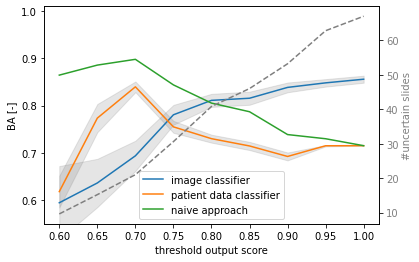

In [10]:
threshold_determination('val')

Conbare: Threshold | Perf_base (Base on subset)   | Perf_fusion (md on subset)
Combare:  s=0.6:   83.17 +/- 0.38 (64.42 +/-2.46)   |  87.47 +/- 0.37 (80.69 +/- 1.15)
Combare:  s=0.65:   83.17 +/- 0.38 (71.18 +/-2.53)   |  87.19 +/- 0.81 (82.06 +/- 2.05)
Combare:  s=0.7:   83.17 +/- 0.38 (72.02 +/-0.9)   |  86.72 +/- 0.36 (78.21 +/- 1.18)
Combare:  s=0.75:   83.17 +/- 0.38 (72.92 +/-0.91)   |  85.64 +/- 0.69 (75.65 +/- 1.32)
Combare:  s=0.8:   83.17 +/- 0.38 (76.58 +/-0.92)   |  82.13 +/- 0.78 (73.57 +/- 0.87)
Combare:  s=0.85:   83.17 +/- 0.38 (79.27 +/-0.69)   |  78.61 +/- 0.31 (72.94 +/- 0.24)
Combare:  s=0.9:   83.17 +/- 0.38 (81.5 +/-0.26)   |  75.4 +/- 0.78 (73.17 +/- 0.31)
Combare:  s=0.95:   83.17 +/- 0.38 (82.89 +/-0.45)   |  73.0 +/- 0.76 (72.74 +/- 0.58)
Combare:  s=1.0:   83.17 +/- 0.38 (83.17 +/-0.38)   |  71.95 +/- 0.0 (71.95 +/- 0.0)


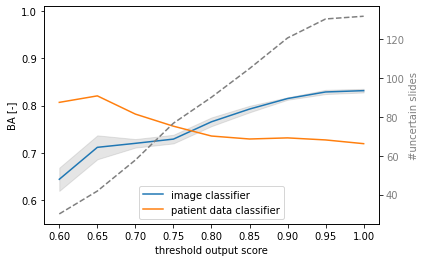

In [11]:
threshold_determination('test')

Naive Approach: Results (s <= 0.7)
----------------

In [12]:
def naive_approach(RFC):
    aucs_over_folds = []
    bas_over_folds = []
    for fold in range(0,5):
        slides_preds = np.asarray(results_over_folds_test['base_fold_' + str(fold)]['slides_preds']) 
        slides_labels = np.asarray(results_over_folds_test['base_fold_' + str(fold)]['slides_label']) 
        slides_output = np.asarray(results_over_folds_test['base_fold_' + str(fold)]['slides_output']) 
        slides_included = np.asarray(results_over_folds_test['base_fold_' + str(fold)]['slides_included'])  
        test_x = []
        test_y = []
        for idx in slides_included:
            test_x.append([hparams.combined_metadata[md][idx] for md in hparams.metadata_list])
            test_y.append(hparams.combined_metadata.label[idx])
        y_pred_rf = RFC.predict(test_x)
        rf_ouputs = RFC.predict_proba(test_x)

        scores = []
        for sp, so in zip(slides_preds, slides_output):
                scores.append(so[sp])
        rf_scores = []
        for sp, so in zip(y_pred_rf,  rf_ouputs):
                rf_scores.append(so[sp])
        
        scores = np.asarray(scores)
        scores_fusion = []
        predictions = []
        for c, s in enumerate(scores):
            if s <= 0.7: 
                scores_fusion.append(rf_scores[c])
                predictions.append(y_pred_rf[c])
            else: 
                scores_fusion.append(scores[c])
                predictions.append(slides_preds[c])
      
        scores_fusions = [score if p == 1 else 1-score for score,p in zip(scores_fusion, predictions)]
        aucs_over_folds.append(roc_auc_score(slides_labels, scores_fusions))
        bas_over_folds.append(balanced_accuracy_score(slides_labels, predictions))

    aucs_over_folds = np.asarray(aucs_over_folds)
    bas_over_folds = np.asarray(bas_over_folds)
    print('Results of the naive appraoch on the test set for s <=0.7')
    print('AUROC: {} % +/- {} %'.format(round(np.mean(aucs_over_folds)*100,2), round(np.std(aucs_over_folds)*100,2)))
    print('BA: {} % +/- {} %'.format(round(np.mean(bas_over_folds)*100,2), round(np.std(bas_over_folds)*100,2)))

In [13]:
naive_approach(RFC)

Results of the naive appraoch on the test set for s <=0.7
AUROC: 89.3 % +/- 0.45 %
BA: 86.72 % +/- 0.36 %


Performance of the fusion models on slides, where the CNN was "uncertain" (supplementary table 3)  
-------------------------

In [14]:
def performance_of_the_fusions_on_uncertain_slides(hp):
    "Take the scores and divide the test set in secure and unsecure decisions; Function for the baseline"
    for v in [0.6, 0.65, 0.7]: 
        print('Threshold score s: ', v)
        su = {}
        for fold in range(0,5):
            #results_over_folds_f['fold_'+str(fold)] 
            slides_preds_f = np.asarray(results_over_folds_test[hp.mode + '_fold_' + str(fold)]['slides_preds']) 
            slides_labels_f = np.asarray(results_over_folds_test[hp.mode + '_fold_' + str(fold)]['slides_label']) 
            slides_output_f = np.asarray(results_over_folds_test[hp.mode + '_fold_' + str(fold)]['slides_output']) 

            slides_preds = np.asarray(results_over_folds_test['base_fold_' + str(fold)]['slides_preds']) 
            slides_labels = np.asarray(results_over_folds_test['base_fold_' + str(fold)]['slides_label']) 
            slides_output = np.asarray(results_over_folds_test['base_fold_' + str(fold)]['slides_output']) 

            scores = []
            mode = 'base'
            if mode in ['base', 'approach_1']:
                for sp, so in zip(slides_preds, slides_output):
                    scores.append(so[sp])
            else: 
                scores = [so if so > 0.5 else 1-so for so in slides_output]
            scores = np.asarray(scores)
            secures = np.where(scores > v)[0]
            unsecures = np.where(scores <= v)[0]

            preds_secure = slides_preds_f[secures]
            labels_secure = slides_labels_f[secures]
            preds_unsecure = slides_preds_f[unsecures]
            labels_unsecure = slides_labels_f[unsecures]
         
            ba_secure = balanced_accuracy_score(labels_secure, preds_secure)
            ba_unsecure = balanced_accuracy_score(labels_unsecure, preds_unsecure)
            su['fold_'+str(fold)] = {'secure': secures, 'unsecures': unsecures, 'ba_secure': ba_secure, 'ba_unsecure': ba_unsecure}
        unsecure_mean = np.mean(np.asarray([su['fold_'+str(fold)]['ba_unsecure'] for fold in range(0,5)]))
        unsecure_std = np.std(np.asarray([su['fold_'+str(fold)]['ba_unsecure'] for fold in range(0,5)]))
        print("Balanced accuracy: {}% +/- {}%".format(round(unsecure_mean*100,2), round(unsecure_std*100,2)))
   


In [15]:
app = ['weighted', 'CAT', 'SE']
params = [hparams_weighted, hparams_cat, hparams_se]
for hp, app in zip(params, names): 
    print(app)
    performance_of_the_fusions_on_uncertain_slides(hp)
    

weighted
Threshold score s:  0.6
Balanced accuracy: 67.04% +/- 5.41%
Threshold score s:  0.65
Balanced accuracy: 66.18% +/- 4.54%
Threshold score s:  0.7
Balanced accuracy: 65.52% +/- 5.03%
CAT
Threshold score s:  0.6
Balanced accuracy: 63.9% +/- 5.19%
Threshold score s:  0.65
Balanced accuracy: 64.87% +/- 2.78%
Threshold score s:  0.7
Balanced accuracy: 67.9% +/- 1.5%
SE
Threshold score s:  0.6
Balanced accuracy: 76.62% +/- 2.61%
Threshold score s:  0.65
Balanced accuracy: 75.83% +/- 3.68%
Threshold score s:  0.7
Balanced accuracy: 72.41% +/- 4.68%
